![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [377]:
import warnings
warnings.filterwarnings('ignore')

In [378]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [379]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [380]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [381]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [382]:
bikes.describe()[['season', 'hour']]

,season,hour
count,10886.000000,10886.000000
mean,2.506614,11.541613
std,1.116174,6.915838
min,1.000000,0.000000
25%,2.000000,6.000000
50%,3.000000,12.000000
75%,4.000000,18.000000
max,4.000000,23.000000


Parece que solo existen valores con sentido. "Season" es una de las cuatro estaciones y "hour" es una de las horas del día. Sus rangos tienen sentido en función de la definición de los datos.

En el caso de "hour", parece que a priori es una variable con cierta uniformidad, dado el comportamiento de los percentiles presentados y que la media tiende a ser 12. "Season" parece tener más datos en torno al 3, pero con un comportamiento relativamente uniforme. Estas hipótesis se validan mediante diagramas de barras:

<AxesSubplot:xlabel='season'>

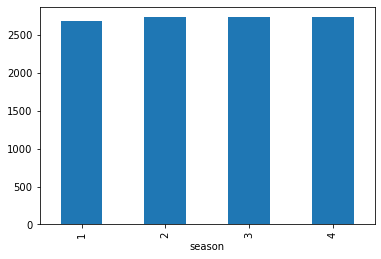

In [383]:
bikes.groupby("season").count()["hour"].plot(kind="bar")
# se plotea el barchart

In [384]:
bikes.groupby('season').count()['hour']
# se observan los valores, notando que en el season 1 hay un menor valor. Esto es lo que causa la impresión inicial

season
1    2686
2    2733
3    2733
4    2734
Name: hour, dtype: int64

<AxesSubplot:xlabel='hour'>

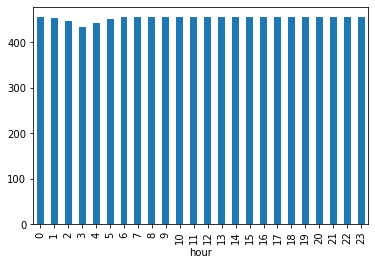

In [385]:
bikes.groupby("hour").count()["season"].plot(kind="bar")
# de plotea el bar chart. Se ve que en general las horas son similares sus valores

In [386]:
bikes.groupby("hour").count()["season"]
# Todas las horas tienden al mismo valor excepto alrededor de las 3 (de 2 a 4 cambia el valor)

hour
0     455
1     454
2     448
3     433
4     442
5     452
6     455
7     455
8     455
9     455
10    455
11    455
12    456
13    456
14    456
15    456
16    456
17    456
18    456
19    456
20    456
21    456
22    456
23    456
Name: season, dtype: int64

Los datos en general parecen tener una distribución uniforme coherente con el diccionario de datos.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

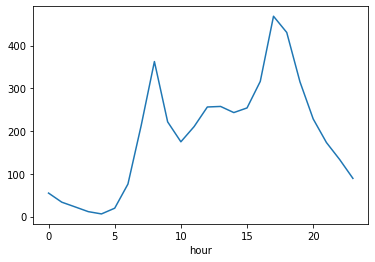

In [387]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby("hour").total.mean().plot()

<AxesSubplot:xlabel='hour'>

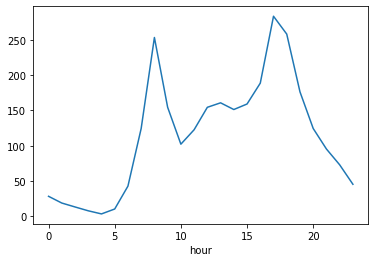

In [388]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos
winter = bikes[bikes["season"] == 1].copy()
winter.groupby("hour").total.mean().plot()

<AxesSubplot:xlabel='hour'>

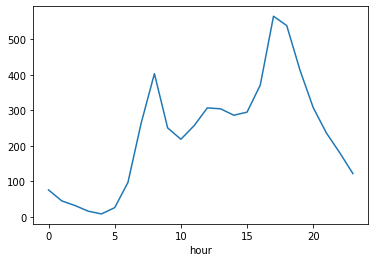

In [389]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos
summer = bikes[bikes["season"] == 3].copy()
summer.groupby("hour").total.mean().plot()

El comportamiento de la media tiende a ser muy similar para el número promedio de bicicletas rentadas para cada valor de la variable hour, tanto a nivel global como en verano. Sin embargo, cuando la variable season es igual a 1 (en invierno), se observa un comportamiento marcadamente diferente, con una disminución en la media. Los picos que se observaban cerca de las 7 y las 17 horas, que llegaban hasta cerca de 400 y 550, respectivamente, solo llegan hasta cerca de 250 en invierno. En general, **parece que se alquilan menos bicicletas en invierno, pero el comportamiento de los alquileres en función de la hora parece mantenerse constante.**

A continuación, se observará el season a nivel general:

<AxesSubplot:xlabel='season'>

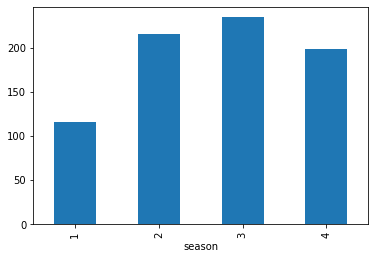

In [390]:
bikes.groupby('season').total.mean().plot(kind = 'bar')

Parece ser que para cada estación, el total de alquileres varia (podría pensarse que por el clima, ya que la estación mas baja es season=1 que es invierno, la más fría)

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [391]:
# Celda 3
# Paso 0: se extraen los datos a usar.

data3 = bikes[["total", "season", "hour"]].copy()

# Paso 1: tratamiento de la variable season.

# se convierte en una categoria clásica para tratamiento
seasons = {1: "winter", 2: "spring", 3: "summer", 4: "fall"}

data3["season"] = data3["season"].replace(seasons)


# Paso 2: Tratamiento de datos. Separación de datos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = data3.total
X = data3.drop("total", axis=1)
# Obtener dummies quitando una para respetar el supuesto de no multicolinealidad
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=4269
)

# Paso 3: Entrenar una regresión simple
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [392]:
pd.DataFrame(data= [lr.coef_], columns = lr.feature_names_in_)

,hour,season_spring,season_summer,season_winter
0,10.436436,15.281672,36.247784,-81.757173



Los coeficientes se interpretan de la siguiente manera:

1. Manteniendo todo lo demás constante, un incremento en la variable "hour" de una unidad genera un incremento promedio de 10.436436 unidades en la variable respuesta "total". Es decir, en promedio, cada hora del día se alquilan 10 bicicletas más.
2. Para los otros coeficientes y manteniendo todo lo demás constante, cada coeficiente representa el cambio en función de la categoría de referencia "fall". Es decir, por ejemplo, el coeficiente de "season_spring" quiere decir que cuando la estación es primavera, en promedio se alquilan 15.281672 bicicletas más que cuando la estación es otoño.

De los coeficientes, podemos ver que la estación con menos alquileres es invierno y la que más alquileres tiene es verano.

Una limitación que tiene la regresión lineal es que "promedia" los efectos de los niveles. En el tratamiento que se dio para las estaciones, podemos ver que los niveles son diferentes. Pero si observamos la hora:

<AxesSubplot:xlabel='hour'>

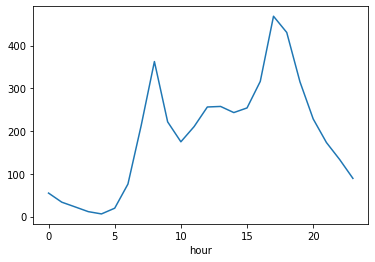

In [393]:
bikes.groupby('hour').total.mean().plot()

La regresión generalmente refleja una tendencia creciente y su coeficiente se promedia en la "caja". El crecimiento general es de 10.436436, pero este valor no tiene en cuenta los picos que ocurren en ciertas horas.

Si ocurre algo similar a lo que sucede con la estacionalidad, donde cada variable tiene un nivel marcadamente diferente (para cada estación, hay un efecto diferente sobre la variable respuesta), este efecto se "perdería" en el coeficiente de la regresión.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [394]:
# Celda 4
# Paso 0: carga de datos y de funciones de interés adaptadas de los otros notebooks del curso
# Codigo hecho a mano y adaptado de https://github.com/rizaozcelik/cmpe462-spring20/blob/master/RegressionTree/RegressionTree.ipynb


data4 = bikes[["total", "season", "hour"]].copy()

y = data4.total
X = data4.drop("total", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=4269
)

from sklearn import metrics
import numpy as np


def rss(y_left, y_right):
    
    # Un posible criterio de métrica, calcular el Squared error
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right)




def best_split(X, y):
    # Se inicia de valores vacios
    best_feat, best_thres, min_rss = None, None, np.inf
    
    # Para cada columna
    for feat in X.columns:
        # Se eligen sus valores únicos ordenados
        thres_list = list(X[feat].unique())
        thres_list.sort()
        thres_list = thres_list[1:]
        # para cada valor único en la columna actual
        for thres in thres_list:
            
            # Se separan los datos según el valor único de la columna actual
            left_ix = X[feat] < thres
            left, right = y[left_ix], y[~left_ix]
            thres_rss =rss(left, right)
            # se estima el RSS y se compara con el menor actual
            if thres_rss < min_rss:
                # Para el menor RSS, se hace el split en ese valor
                min_rss = thres_rss
                best_feat = feat
                best_thres = thres
                
    # Al final de la búsqueda, se obtiene el split con el menor RSS
    return {"feature": best_feat, "threshold": best_thres, 'rss':min_rss}


def split_tree(X, y, current_depth, max_depth):
    
    # Si se llega a la profundidad máxima o no hay items para hacer un split, predecir
    
    if current_depth == max_depth or len(X) <= 2 :
        return {"pred": np.mean(y)}
    
    # Hacer el split
    split = best_split(X, y)
    left_ix = X[split["feature"]] < split["threshold"]
    # Intentar seguir iterando en ambos lados.
    try:
        split["left"] = split_tree(X[left_ix], y[left_ix], current_depth + 1, max_depth)
        split["right"] = split_tree(X[~left_ix], y[~left_ix], current_depth + 1, max_depth)
        
        
    # Por el error de que no haya splits posibles y lo siga intentando, se usa un except para devolver la predicción
    except:
        
        return {"pred": np.mean(y)}
        
   
    return split

In [395]:
# Para que tenga al menos 6 nodos finales, minima profundidad sería 3. Pongamos 5
tree= split_tree(X_train, y_train, 0, 5)
tree

{'feature': 'hour',
 'threshold': 7,
 'rss': 191580563.9924449,
 'left': {'feature': 'hour',
  'threshold': 6,
  'rss': 3116361.253989337,
  'left': {'feature': 'hour',
   'threshold': 2,
   'rss': 1654654.8085287667,
   'left': {'feature': 'season',
    'threshold': 2,
    'rss': 1137355.2662904912,
    'left': {'feature': 'hour',
     'threshold': 1,
     'rss': 93446.17815482503,
     'left': {'pred': 27.73913043478261},
     'right': {'pred': 20.341463414634145}},
    'right': {'feature': 'hour',
     'threshold': 1,
     'rss': 942499.9861404994,
     'left': {'pred': 64.88970588235294},
     'right': {'pred': 38.05035971223022}}},
   'right': {'feature': 'hour',
    'threshold': 3,
    'rss': 399657.13355398376,
    'left': {'feature': 'season',
     'threshold': 2,
     'rss': 227303.7144082333,
     'left': {'pred': 13.795454545454545},
     'right': {'pred': 24.39622641509434}},
    'right': {'feature': 'hour',
     'threshold': 5,
     'rss': 134819.84783951752,
     'left': 

In [396]:
def predict(sample, rules):
    
    # La predicción es nula
    prediction = None
    while prediction is None:
        
        # Se explora el arbol iterativamente hasta llegar a un nodo predict 'pred'
        
        # Solo por si por algún motivo algo pasa mal, que no siga entrando y salga
        if prediction is not None:
            return prediction
        
        # Se obtienen los parámetros del nodo actual
        feature, threshold = rules['feature'], rules['threshold']
        
        # Elegir por que lado irse en el arbol, si izquierda o derecha.
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
            
        # Dado que solo hay predicciones al final, esto hará que siga buscando hasta acabar un nodo
        prediction = rules.get('pred', None)
       
        
    return prediction

def evaluate(X, y, metric = metrics.mean_squared_error):
    
    # Predice para todas las x usando el arbol
    
    # Usar una copia del arbol original para evitar problemas.
    preds = X.apply(predict, axis='columns', rules=tree.copy())
    #Devuelve la métrica dada
    return metric(preds, y)

In [397]:
evaluate(X_train, y_train)

14335.064341511212

In [398]:
evaluate(X_test, y_test)

15171.15346197143

In [399]:
evaluate(X_train, y_train, metrics.r2_score)

0.19546520661572964

In [400]:
evaluate(X_test, y_test, metrics.r2_score)

0.1778372431986126

El árbol tiende a tener un sobreajuste muy leve, pero tiene un desempeño similar en ambos conjuntos de entrenamiento y prueba.

Sin embargo, su desempeño no es muy bueno, con un bajo R2 y un alto MSE.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [401]:
# Celda 5
#Los datos ya estaban dividos en ambos conjuntos del punto anterior.


from sklearn.tree import DecisionTreeRegressor
TreeRegressor= DecisionTreeRegressor(random_state=4269,
                                    min_impurity_decrease=0.01,
                                    min_samples_leaf=2,
                                    criterion='friedman_mse')

TreeRegressor.fit(X_train, y_train)


metrics.r2_score(TreeRegressor.predict(X_test), y_test)


0.3237582737737519

In [402]:
metrics.r2_score(TreeRegressor.predict(X_train), y_train)


0.35387281477309696

In [403]:
metrics.mean_squared_error(TreeRegressor.predict(X_test), y_test)


13535.107325089599

In [404]:
metrics.mean_squared_error(TreeRegressor.predict(X_train), y_train)


12620.445999467745

El modelo tiene un mejor desempeño que el realizado a mano (como se esperaba), mejorando el puntaje R2 y disminuyendo el MSE.

Existe un leve sobreajuste, pero no es grave, ya que el modelo presenta desempeños similares para los conjuntos de entrenamiento y prueba.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [405]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-report-whats-next/,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kickstarter/,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-porn-clip/,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-most-shared-ads-of-2013/,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-prank/,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [406]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [407]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [408]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
# ARBOL:

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 42)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []


for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


Text(0, 0.5, 'Accuracy')

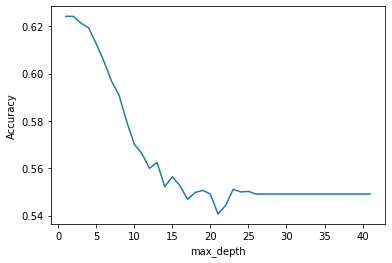

In [409]:
# Gráfica max_depth versus RMSE (error del modelo)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


# Dada la grafica, se toma profundidad = 2

In [410]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6242222222222222, 2)

In [411]:
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=2, random_state=1)

In [412]:
metrics.accuracy_score(y_test, clf.predict(X_test))

0.6453333333333333

In [413]:
metrics.accuracy_score(y_train, clf.predict(X_train))

0.6326666666666667

In [414]:
metrics.f1_score(y_test, clf.predict(X_test))

0.6448598130841121

In [415]:
metrics.f1_score(y_train, clf.predict(X_train))

0.628956228956229

In [416]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X_test, y_test, cv=10)).describe()

count    10.000000
mean      0.646667
std       0.035970
min       0.593333
25%       0.618333
50%       0.653333
75%       0.665000
max       0.713333
dtype: float64

In [417]:
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.630889
std       0.014304
min       0.606667
25%       0.624444
50%       0.634444
75%       0.640000
max       0.653333
dtype: float64

El desempeño del arbol parece ser bueno, con un f1 score y un accuracy mejores que el modelo base (lanzar una moneda).

No parecen existir signos de un overfit extremo, siendo las métricas en train y test de valores similares.

Usemos el árbol como una forma de selección de variables para la regresión (tomemos solo de los 10 feature importances más altos):

<AxesSubplot:>

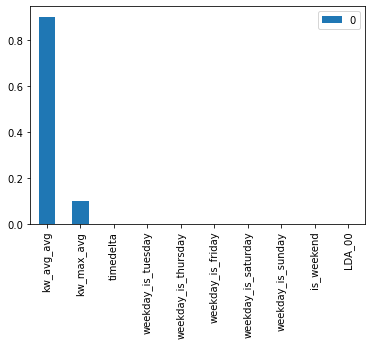

In [418]:
pd.DataFrame(
    columns=clf.feature_names_in_, data=[clf.feature_importances_]
).T.sort_values(by=0, ascending=False).head(10).plot(kind="bar")

In [419]:
lr = LogisticRegression().fit(X_train[['kw_avg_avg', 'kw_max_avg']], y_train)

In [420]:
metrics.accuracy_score(y_test, lr.predict(X_test[['kw_avg_avg', 'kw_max_avg']]))

0.5053333333333333

In [421]:
metrics.accuracy_score(y_train, lr.predict(X_train[['kw_avg_avg', 'kw_max_avg']]))

0.49866666666666665

In [422]:
metrics.f1_score(y_test, lr.predict(X_test[['kw_avg_avg', 'kw_max_avg']]))

0.6705150976909415

In [423]:
metrics.f1_score(y_train, lr.predict(X_train[['kw_avg_avg', 'kw_max_avg']]))

0.665083135391924

La regresión logística aplicada tiene peor desempeño que el árbol en términos generales, incluso rozando el azar al tener un acc. de cerca del 0.5 (mejor lanzar una moneda). Probemos sin hacer ese feature selectiona ver cómo resulta:

In [424]:
lr2 = LogisticRegression().fit(X_train, y_train)

In [425]:
metrics.accuracy_score(y_test, lr2.predict(X_test))

0.6133333333333333

In [426]:
metrics.accuracy_score(y_train, lr2.predict(X_train))

0.6135555555555555

In [427]:
metrics.f1_score(y_test, lr2.predict(X_test))

0.6102150537634409

In [428]:
metrics.f1_score(y_train, lr2.predict(X_train))

0.6061155152887883

El modelo tiene un peor puntaje F1, pero una mejor precisión. Esto sugiere que el modelo comienza a predecir mejor una clase, pero no la otra, con la información adicional.

Parece que las variables 'kw_avg_avg' y 'kw_max_avg' contienen información para clasificar con cierto nivel de certeza alguna de las dos clases, pero que otras variables contienen información para predecir mejor la otra clase.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [429]:
# Celda 7
from sklearn.ensemble import BaggingClassifier
bagrega = BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100, 
                          bootstrap=True, oob_score=True, random_state=4269)
bagregb = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=100, 
                          bootstrap=True, oob_score=True, random_state=4269)
bagregc = BaggingClassifier(LogisticRegression(), n_estimators=100, 
                          bootstrap=True, oob_score=True, random_state=4269)

models = {'Bagg  -  Max Depth  =  2': bagrega, 'Bagg - Min Samples Leaf=10':bagregb, 'Bag - Regresión logística': bagregc}

In [430]:
for name in models:
    models[name].fit(X_train, y_train)
    


In [431]:
print("ACCURACY EN TEST")
for name in models:
    print(name, "\t", metrics.accuracy_score(y_test, models[name].predict(X_test)))
print("ACCURACY EN TRAIN")
for name in models:
    print(name, "\t", metrics.accuracy_score(y_train, models[name].predict(X_train)))

ACCURACY EN TEST
Bagg  -  Max Depth  =  2 	 0.6453333333333333
Bagg - Min Samples Leaf=10 	 0.6526666666666666
Bag - Regresión logística 	 0.618
ACCURACY EN TRAIN
Bagg  -  Max Depth  =  2 	 0.6335555555555555
Bagg - Min Samples Leaf=10 	 0.9053333333333333
Bag - Regresión logística 	 0.6204444444444445


In [432]:
print("f1 EN TEST")
for name in models:
    print(name, "\t", metrics.f1_score(y_test, models[name].predict(X_test)))
print("f1 EN TRAIN")
for name in models:
    print(name, "\t", metrics.f1_score(y_train, models[name].predict(X_train)))

f1 EN TEST
Bagg  -  Max Depth  =  2 	 0.6434316353887399
Bagg - Min Samples Leaf=10 	 0.6570111915734035
Bag - Regresión logística 	 0.613099257258609
f1 EN TRAIN
Bagg  -  Max Depth  =  2 	 0.628184892897407
Bagg - Min Samples Leaf=10 	 0.9055851063829787
Bag - Regresión logística 	 0.6118181818181817


In [433]:
# Armar un dataframe para armar la predicción

y_pred_train = X_train.copy()
for name in models:
    y_pred_train[f'Model_{name}'] = models[name].predict(X_train)

y_pred_train = y_pred_train[[x for x in y_pred_train.columns if "Model_" in x]]
y_pred_train['Prediccion'] = 0
y_pred_train['Prediccion'] =y_pred_train.apply(lambda x: int(np.round(sum(x[:-1])/3)), axis=1)
y_pred_train

,Model_Bagg - Max Depth = 2,Model_Bagg - Min Samples Leaf=10,Model_Bag - Regresión logística,Prediccion
2420,1,1,1,1
1225,1,1,0,1
324,0,0,0,0
5863,1,1,0,1
86,1,1,0,1
...,...,...,...,...
905,0,0,0,0
5192,1,1,1,1
3980,0,1,1,1
235,1,1,1,1


In [434]:
# Armar un dataframe para armar la predicción, con la pereza de hacer una función para esto pero se que debería


y_pred = X_test.copy()
for name in models:
    y_pred[f'Model_{name}'] = models[name].predict(X_test)

y_pred = y_pred[[x for x in y_pred.columns if "Model_" in x]]
y_pred['Prediccion'] = 0
y_pred['Prediccion'] =y_pred.apply(lambda x: int(np.round(sum(x[:-1])/3)), axis=1)
y_pred

,Model_Bagg - Max Depth = 2,Model_Bagg - Min Samples Leaf=10,Model_Bag - Regresión logística,Prediccion
1483,1,1,1,1
2185,1,1,1,1
2520,1,1,1,1
3721,1,1,1,1
3727,0,0,0,0
...,...,...,...,...
3077,1,0,0,0
5166,0,0,0,0
2227,1,1,1,1
5684,0,0,0,0


In [435]:
metrics.accuracy_score(y_train, y_pred_train['Prediccion'])

0.7164444444444444

In [436]:
metrics.accuracy_score(y_test, y_pred['Prediccion'])

0.652

In [437]:
metrics.f1_score(y_train, y_pred_train['Prediccion'])

0.7115732368896927

In [438]:
metrics.f1_score(y_test, y_pred['Prediccion'])

0.6491935483870968

En general, los resultados tienden a ser una especie de "promedio" de los resultados de los modelos (lo cual tiene cierto sentido, dado la forma en que se realiza la predicción).

En particular, se observa un leve sobreajuste y métricas similares entre train y test. Uno de los modelos que utilizamos presentaba un sobreajuste severo (60-70 vs 90-99), el cual se vio mitigado al realizar un ensemble.

Este ensemble toma parte de lo que generó el sobreajuste del modelo por separado, y a través de un método de aprendizaje, mejora el desempeño global del modelo en comparación con los modelos individuales.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [439]:
# Celda 8

# Me entra la duda de si desea que haga los 3 modelos y la votación ponderada de los 3 o...
# si es hacer para los 3 casos votación ponderada.

# Entrada la duda, probemos todo (además de permitir entender mejor el método)


# CLASIFICADOR PONDERANDO LOS TRES CLASIFICADORES:

from sklearn.ensemble import BaggingClassifier
bagrega = BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269)
bagregb = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269)
bagregc = BaggingClassifier(LogisticRegression(), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269)

models = {'Bagg  -  Max Depth  =  2': bagrega, 'Bagg - Min Samples Leaf=5':bagregb, 'Bag - Regresión logística': bagregc}

for name in models:
    models[name].fit(X_train, y_train)

In [440]:
# para la votación ponderada, se toma el oob_score_ de cada modelo obtenido y se pondera:

oob_scores = []


for name in models:
    oob_scores.append(1-models[name].oob_score_)


alphas = oob_scores/sum(oob_scores)
alphas

array([0.3320024 , 0.32421641, 0.34378119])

In [441]:
y_pred = X_test.copy()
for name in models:
    y_pred[f'Model_{name}'] = models[name].predict(X_test)

y_pred = y_pred[[x for x in y_pred.columns if "Model_" in x]]
y_pred['Prediccion'] =y_pred.apply(lambda x: int(sum(x * alphas) >=0.5), axis=1)
y_pred

,Model_Bagg - Max Depth = 2,Model_Bagg - Min Samples Leaf=5,Model_Bag - Regresión logística,Prediccion
1483,1,1,1,1
2185,1,1,1,1
2520,1,1,1,1
3721,1,1,1,1
3727,0,0,0,0
...,...,...,...,...
3077,1,0,0,0
5166,0,0,0,0
2227,1,1,1,1
5684,0,0,0,0


In [442]:
y_pred_train = X_train.copy()
for name in models:
     y_pred_train[f'Model_{name}'] = models[name].predict(X_train)

y_pred_train =  y_pred_train[[x for x in  y_pred_train.columns if "Model_" in x]]
y_pred_train['Prediccion'] = y_pred_train.apply(lambda x: int(sum(x * alphas) >=0.5), axis=1)
y_pred_train

,Model_Bagg - Max Depth = 2,Model_Bagg - Min Samples Leaf=5,Model_Bag - Regresión logística,Prediccion
2420,1,1,1,1
1225,1,1,0,1
324,0,0,0,0
5863,1,1,0,1
86,1,1,0,1
...,...,...,...,...
905,0,0,0,0
5192,1,1,1,1
3980,0,1,1,1
235,1,1,1,1


Se calculan las métricas:

In [443]:
metrics.accuracy_score(y_train, y_pred_train['Prediccion'])

0.7208888888888889

In [444]:
metrics.accuracy_score(y_test, y_pred['Prediccion'])

0.6506666666666666

In [445]:
metrics.f1_score(y_train, y_pred_train['Prediccion'])

0.7159656264133876

In [446]:
metrics.f1_score(y_test, y_pred['Prediccion'])

0.6469002695417789

Ahora, para cada uno de los clasificadores, se realiza el proceso de votación ponderada:

In [447]:
# Votación ponderada para cada clasificador por aparte según sus errores
# Esto es, haciendo votación ponderada dentro del bagging qeu realizan los modelos.

def votacion_ponderada(clf, X_train, X_test, y_train, y_test):
    # Predicción y desempeño al hacer votación mayoritaria
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)
    # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
    errors = np.zeros(clf.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

    for i in range(clf.n_estimators):
        oob_sample = ~clf.estimators_samples_[i]
        y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
    # Desempeño al hacer votación ponderada
    print("f1", metrics.f1_score(y_pred, y_test))
    print("Accuracy", metrics.accuracy_score(y_pred, y_test))


In [448]:
votacion_ponderada(BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269), X_train, X_test, y_train, y_test)

f1 0.6439545758183033
Accuracy 0.6446666666666667


In [449]:
votacion_ponderada(BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269), X_train,  X_train, y_train, y_train)

f1 0.6276978417266187
Accuracy 0.632


In [450]:
votacion_ponderada(BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269), X_train, X_test, y_train, y_test)

f1 0.6500672947510093
Accuracy 0.6533333333333333


In [451]:
votacion_ponderada(BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269), X_train, X_train, y_train, y_train)

f1 0.921383647798742
Accuracy 0.9222222222222223


In [452]:
votacion_ponderada(BaggingClassifier(LogisticRegression(), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269), X_train, X_test, y_train, y_test)


f1 0.6108108108108109
Accuracy 0.616


In [453]:
votacion_ponderada(BaggingClassifier(LogisticRegression(), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269), X_train, X_train, y_train, y_train)


f1 0.6072080291970803
Accuracy 0.6173333333333333


Por último, como bonus (para explorar más alternativas), se toma cada uno de los modelos y se realiza una votación ponderada usando todos los posibles clasificadores. A priori, estimaría que este debe ser el peor modelo, pues sospecho que matemáticamente debe tender a ponderar a 0.5 y ser casi igual a tirar una moneda. Esto se debe a que espero que con 900 modelos, el error tienda a no ser tan diferente en los datos, y más viéndolos como son, y que el peso de los buenos predictores se vea "diluido" por los 600 modelos de los otros modelos. Creo que la forma en que se estima el peso no tendría buen desempeño dados los datos que se tienen.


In [454]:
# Votación ponderada de los clasificadores
# Se pondera para una lista de bagger classifiers cada uno de sus clasificadores individuales.



def votacion_ponderada_multi_modelo(clfs, X_train, X_test, y_train, y_test):
    # Predicción y desempeño al hacer votación mayoritaria
    y_pred_all_clfs =[]
    errors_clf=[]
    for clf in clfs:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)
        # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
        errors = np.zeros(clf.n_estimators)
        y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

        for i in range(clf.n_estimators):
            oob_sample = ~clf.estimators_samples_[i]
            y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
            errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
            y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
        errors_clf.append(errors)
        y_pred_all_clfs.append( y_pred_all_)
    errors_clf= np.array(errors_clf)
    y_pred_all_clfs = np.array(y_pred_all_clfs)
    y_pred_all_clfs = y_pred_all_clfs.reshape((X_test.shape[0], 3*clf.n_estimators))
    errors_clf = errors_clf.reshape((3*clf.n_estimators))
    alpha = (1 - errors_clf) / (1 - errors_clf).sum()
    y_pred = (np.sum(y_pred_all_clfs * alpha, axis=1) >= 0.5).astype(np.int)
    # Desempeño al hacer votación ponderada
    print("f1", metrics.f1_score(y_pred, y_test))
    print("Accuracy", metrics.accuracy_score(y_pred, y_test))

In [455]:
clfs= [ BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269),
 BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269),
 BaggingClassifier(LogisticRegression(), n_estimators=300, 
                          bootstrap=True, oob_score=True, random_state=4269)]

In [456]:
votacion_ponderada_multi_modelo(clfs, X_train, X_test, y_train, y_test)

f1 0.4934707903780069
Accuracy 0.5086666666666667


In [457]:
votacion_ponderada_multi_modelo(clfs, X_train, X_train, y_train, y_train)

f1 0.47150735294117646
Accuracy 0.4888888888888889


In [458]:
clfs= [ BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=5, 
                          bootstrap=True, oob_score=True, random_state=4269),
 BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=5, 
                          bootstrap=True, oob_score=True, random_state=4269),
 BaggingClassifier(LogisticRegression(), n_estimators=5, 
                          bootstrap=True, oob_score=True, random_state=4269)]

In [459]:
votacion_ponderada_multi_modelo(clfs, X_train, X_test, y_train, y_test)

f1 0.4827099505998589
Accuracy 0.5113333333333333


In [460]:
votacion_ponderada_multi_modelo(clfs, X_train, X_train, y_train, y_train)

f1 0.4667291471415182
Accuracy 0.49422222222222223


Se obtiene un resultado malo, así se tengan muchos o pocos clasificadores. En dicho experiem

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.


Las métricas de los modelos del punto 7 fueron:

ACCURACY EN TEST

- Bagg - Max Depth = 2: 0.6453333333333333
- Bagg - Min Samples Leaf=10: 0.6526666666666666
- Bag - Regresión logística: 0.618

ACCURACY EN TRAIN

- Bagg - Max Depth = 2: 0.6335555555555555
- Bagg - Min Samples Leaf=10: 0.9053333333333333
- Bag - Regresión logística: 0.6204444444444445

f1 EN TEST

- Bagg - Max Depth = 2: 0.6434316353887399
- Bagg - Min Samples Leaf=10: 0.6570111915734035
- Bag - Regresión logística: 0.613099257258609

f1 EN TRAIN

- Bagg - Max Depth = 2: 0.628184892897407
- Bagg - Min Samples Leaf=10: 0.9055851063829787
- Bag - Regresión logística: 0.6118181818181817

De esto, observamos que los modelos tienen un comportamiento diferente entre sí (el modelo de min samples leaf=10 presenta un overfit severo, teniendo resultados del 90% en train para las métricas pero del 65% en test).

Al aplicar la votación mayoritaria, tenemos:

- ACCURACY EN TEST: 0.652
- ACCURACY EN TRAIN: 0.71644444444444444
- f1 EN TEST: 0.64919354
- f1 EN TRAIN: 0.7115732

Estos resultados mejoran el desempeño global respecto a los modelos de forma individual, ya que las métricas tienen a nivel general un mejor valor que los valores individuales de los modelos: tienen mejores métricas en test y train sin llegar a un overfit, como ocurre en el caso del modelo con min sample leaf=10. Así, es un mejor modelo ya que generaliza mejor.

Para la votación ponderada, se obtienen resultados similares. Esto es porque los alphas estimados con el OOB son:

[0.3320024 , 0.32421641, 0.34378119]

Por tanto, es casi igual a la votación mayoritaria:

- ACCURACY EN TEST: 0.6506
- ACCURACY EN TRAIN: 0.720888888
- f1 EN TEST: 0.64690026
- f1 EN TRAIN: 0.7159656264

Da en general básicamente el mismo resultado que con la votación mayoritaria (es posible que la diferencia sea porque se piden 100 estimadores por modelo para la votación por mayoría pero 300 para la ponderada). Pero, esto tiene sentido por los pesos obtenidos.

Considero que ambos comparten la ventaja de disminuir la complejidad de búsqueda de un posible mejor modelo, permitiendo que el ensamblaje tienda a ser un mejor modelo por cuestiones estadísticas (no es imposible que un modelo individual sea mejor que el ensamblado, solo es menos probable). Esto permite encontrar un mejor modelo más rápido la mayoría de veces.

Para el modelo de votación ponderada, creo que la dificultad de su funcionamiento es la asignación correcta de pesos. En el ejercicio, los modelos tendían a tener un desempeño similar como resultado del bagging y la complejidad de los datos, resultando en un OOB score muy similar para los modelos y por tanto, haciéndolo muy similar a votación mayoritaria (los pesos tienden al 33%). Esto seguramente tiene que ver con el hecho de la cantidad de modelos y que en general tienden a desempeños similares, además de ser un problema de clasificación (si tengo 3 pesos asociados a 3 variables binarias, tendré solo 6 posibles valores de las combinaciones. Si la variable respuesta fuese continua, seguramente vería más claramente las bondades del método).

En general, veo que el desempeño de los modelos ensamblados es mejor que los modelos individuales sin entrar a complejas búsquedas exhaustivas computacionalmente inviables. Combinando modelos sencillos, se puede reducir la varianza y encontrar un mejor modelo que con solo un modelo sencillo, sin elevar el gasto computacional a niveles imprácticos. Hacer la combinación permite aprender de diferentes modelos las diferentes relaciones que pueden detectar.


In [461]:
# Celda 9